In [30]:
import keras
from keras.models import load_model
from keras.models import model_from_json
from sklearn.metrics import roc_curve, auc
import numpy as np
import os
import h5py
import yaml
import pandas as pd
import matplotlib.pyplot as plt

from train import get_features

In [31]:
from collections import namedtuple
Option = namedtuple("MyStruct", "inputModel inputFile tree config jsonModel")

options = Option(
    inputModel = 'example-keras-model-files/KERAS_gru_model_weights.h5',
    inputFile = 'data/processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_withPars_truth_0.z',
    tree = 't_allpar_new',
    config = 'train_config_gru.yml',
    jsonModel = 'example-keras-model-files/KERAS_gru_model.json'
)

print("Loading configuration from", options.config)
config = open(options.config, 'r')
yamlConfig =  yaml.load(config, Loader=yaml.FullLoader)
yamlConfig

Loading configuration from train_config_gru.yml


{'Inputs': ['j1_ptrel',
  'j1_etarot',
  'j1_phirot',
  'j1_erel',
  'j1_deltaR',
  'j1_pdgid',
  'j_index'],
 'Labels': ['j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_index'],
 'KerasModel': 'gru_model',
 'KerasModelRetrain': 'gru_model_constraint',
 'KerasLoss': 'categorical_crossentropy',
 'L1Reg': 0.0001,
 'L1RegR': 0.001,
 'NormalizeInputs': 1,
 'InputType': 'Conv1D',
 'MaxParticles': 20}

In [32]:
json_file = open(options.jsonModel, 'r')
model = model_from_json(json_file.read())
json_file.close()

model.load_weights(options.inputModel)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20, 6)             0         
_________________________________________________________________
gru_selu (GRU)               (None, 20)                1620      
_________________________________________________________________
dense_relu (Dense)           (None, 20)                420       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
rnn_densef (Dense)           (None, 5)                 105       
Total params: 2,145
Trainable params: 2,145
Non-trainable params: 0
_________________________________________________________________


In [33]:
X_train_val, X_test, y_train_val, y_test, labels  = get_features(options, yamlConfig, test_size=0.2)

(5131613,)
('index', 'j_ptfrac', 'j_pt', 'j_eta', 'j_mass', 'j_tau1_b1', 'j_tau2_b1', 'j_tau3_b1', 'j_tau1_b2', 'j_tau2_b2', 'j_tau3_b2', 'j_tau32_b1', 'j_tau32_b2', 'j_zlogz', 'j_c1_b0', 'j_c1_b1', 'j_c1_b2', 'j_c2_b1', 'j_c2_b2', 'j_d2_b1', 'j_d2_b2', 'j_d2_a1_b1', 'j_d2_a1_b2', 'j_m2_b1', 'j_m2_b2', 'j_n2_b1', 'j_n2_b2', 'j_tau1_b1_mmdt', 'j_tau2_b1_mmdt', 'j_tau3_b1_mmdt', 'j_tau1_b2_mmdt', 'j_tau2_b2_mmdt', 'j_tau3_b2_mmdt', 'j_tau32_b1_mmdt', 'j_tau32_b2_mmdt', 'j_c1_b0_mmdt', 'j_c1_b1_mmdt', 'j_c1_b2_mmdt', 'j_c2_b1_mmdt', 'j_c2_b2_mmdt', 'j_d2_b1_mmdt', 'j_d2_b2_mmdt', 'j_d2_a1_b1_mmdt', 'j_d2_a1_b2_mmdt', 'j_m2_b1_mmdt', 'j_m2_b2_mmdt', 'j_n2_b1_mmdt', 'j_n2_b2_mmdt', 'j_mass_trim', 'j_mass_mmdt', 'j_mass_prun', 'j_mass_sdb2', 'j_mass_sdm1', 'j_multiplicity', 'j1_px', 'j1_py', 'j1_pz', 'j1_e', 'j1_pdgid', 'j1_erel', 'j1_pt', 'j1_ptrel', 'j1_eta', 'j1_etarel', 'j1_etarot', 'j1_phi', 'j1_phirel', 'j1_phirot', 'j1_deltaR', 'j1_costheta', 'j1_costhetarel', 'j1_e1mcosthetarel', 'j_

In [34]:
X_test.shape

(19754, 20, 6)

In [35]:
def makeRoc(features_val, labels, labels_val, model, outputDir):
    if 'j_index' in labels: labels.remove('j_index')
    predict_test = model.predict(features_val)
    df = pd.DataFrame()
    fpr = {}
    tpr = {}
    auc1 = {}
    plt.figure()       
    for i, label in enumerate(labels):
        df[label] = labels_val[:,i]
        df[label + '_pred'] = predict_test[:,i]
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(fpr[label],tpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.plot([0, 1], [0, 1], lw=1, color='navy', linestyle='--')
    plt.semilogy()
    plt.ylabel("Background Efficiency")
    plt.xlabel("Signal Efficiency")
    plt.xlim([-0.05, 1.05])
    plt.ylim(0.001,1.05)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.figtext(0.25, 0.90,'GRU ROC Curve',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    plt.savefig('%s/GRUROC.pdf'%(outputDir))
    return predict_test

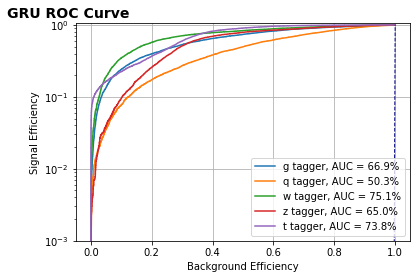

In [36]:
y_pred = makeRoc(X_test, labels, y_test, model, os.curdir)